In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from src.Graph import SingleGeneGraph
from src.Function import read_spatial_expression
from src import Preprocess
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
adata = sc.read_visium("../dataset/goldStandard/")
adata.var_names_make_unique()
adata = Preprocess.data_preprocess(adata, high_var = True, n_top=12000)

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Maki

In [122]:
adata[:,targetGene]

View of AnnData object with n_obs × n_vars = 3636 × 1
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [ ]:
imputedExp = pd.read_csv("./output/1218WithImputed//imputedExp.csv", index_col=0)
label = pd.read_csv("./output/1218WithImputed/label.csv", index_col=0)

In [117]:

plt.rcParams["figure.figsize"] = (8, 8)

In [ ]:
adata[,]

In [6]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
geneList = ["CAMK2N1","PCP4", "NEFM", "NEFH","B3GALT2"]
targetGene = geneList[0]

In [ ]:
for gene in geneList:
    adata.obs[gene+"Imputed"] = imputedExp.loc[:,gene]
    sc.pl.spatial(adata, color=[gene+"Imputed", gene], use_raw=False)

In [ ]:
sc.tl.leiden(adata, key_added="clusters", resolution = 1)
sc.pl.spatial(adata, color=["clusters"], use_raw=False)

In [ ]:
from datetime import date
today = date.today()
d1 = today.strftime("%m%d")

In [ ]:
for gene in geneList:
    adata.obs[gene+"Label"] = label.loc[:,gene]
    sc.pl.spatial(adata, color=[gene+"Label", gene], use_raw=False)

In [114]:
expMatrix = adata.to_df()
coord = adata.obsm["spatial"]
expMatrix.to_csv("dataset/DLPFC/expFull.csv")

In [84]:
geneGraph = SingleGeneGraph(gene_id=targetGene, exp=expMatirx, coord = coord, kneighbors=18, verbose = True)

In [85]:
geneGraph.mrf_with_icmem(beta=3, update_exp=False, alpha=0.8)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

[[ 0.36562712  0.2432149 ]
 [-0.43161124  1.54866517]]


In [86]:
geneGraph.impute()

Imputation finished


In [87]:
adata.obs['label']= geneGraph.label
adata.obs['imputed']= geneGraph.imputedExp

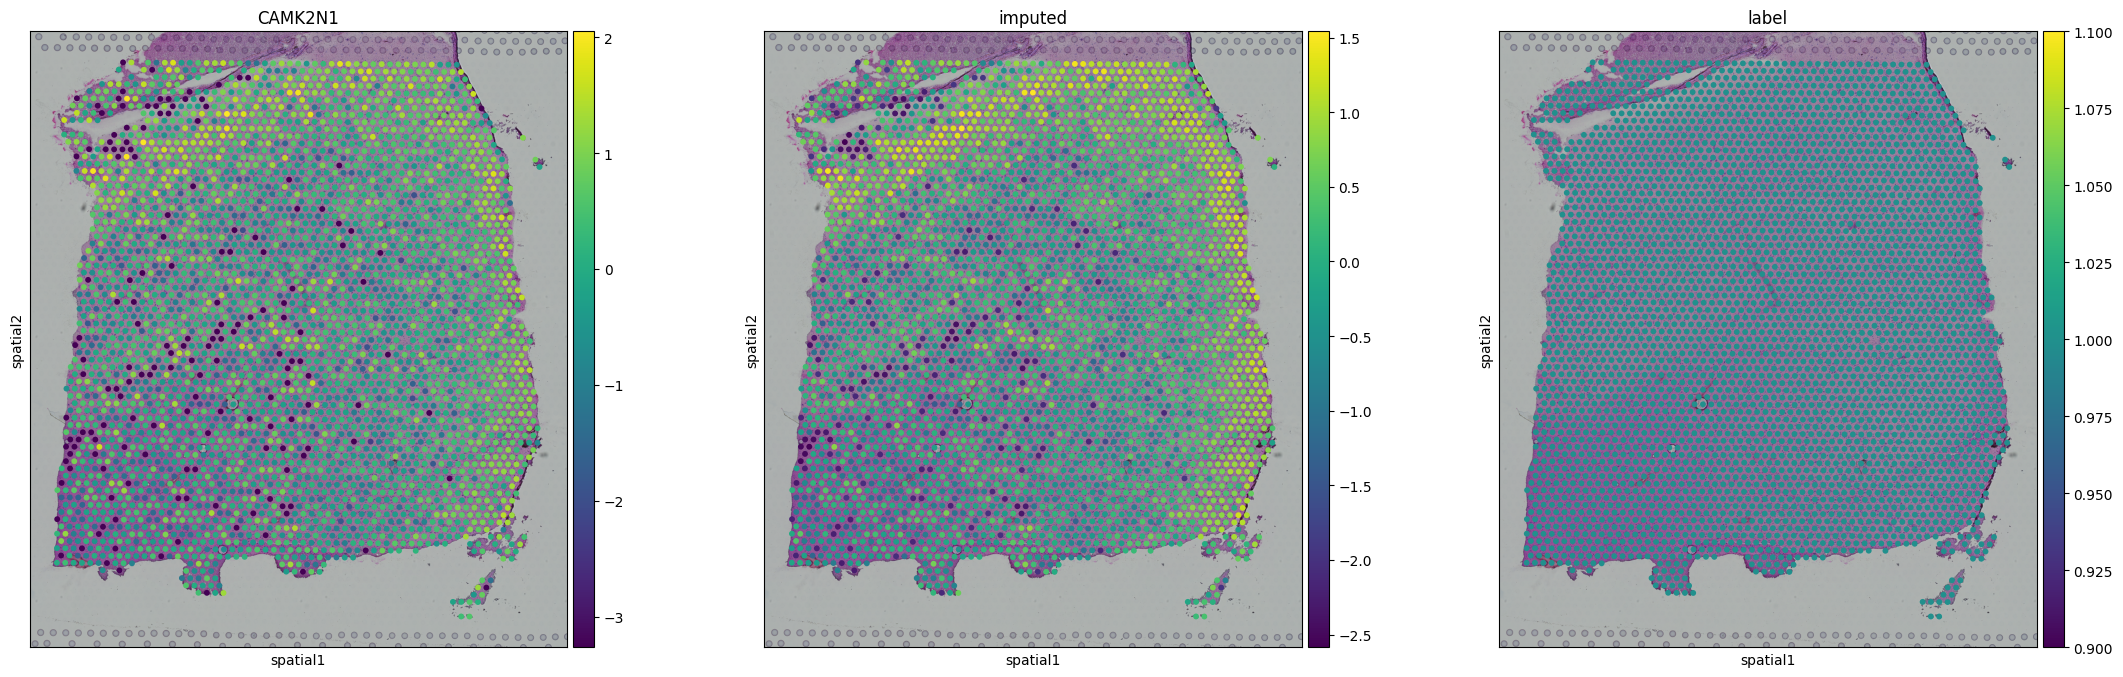

In [88]:
sc.pl.spatial(adata, color=[targetGene, 'imputed','label'])

In [111]:
geneGraph = SingleGeneGraph(gene_id=targetGene, exp=expMatirx, coord = coord, kneighbors=18, verbose = True)
geneGraph.mrf_with_icmem(beta=2, update_exp=True, alpha=0.6, max_iter=10)
geneGraph.impute()

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


[[ 0.03860196  0.17209068]
 [-0.04259599  0.14535196]]
Imputation finished


In [107]:
geneGraph.mrf_with_icmem(beta=3, update_exp=True, alpha=0.6)
geneGraph.impute()

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


[[-0.25688677  0.02003602]
 [ 0.35134814  0.09268965]]
Imputation finished


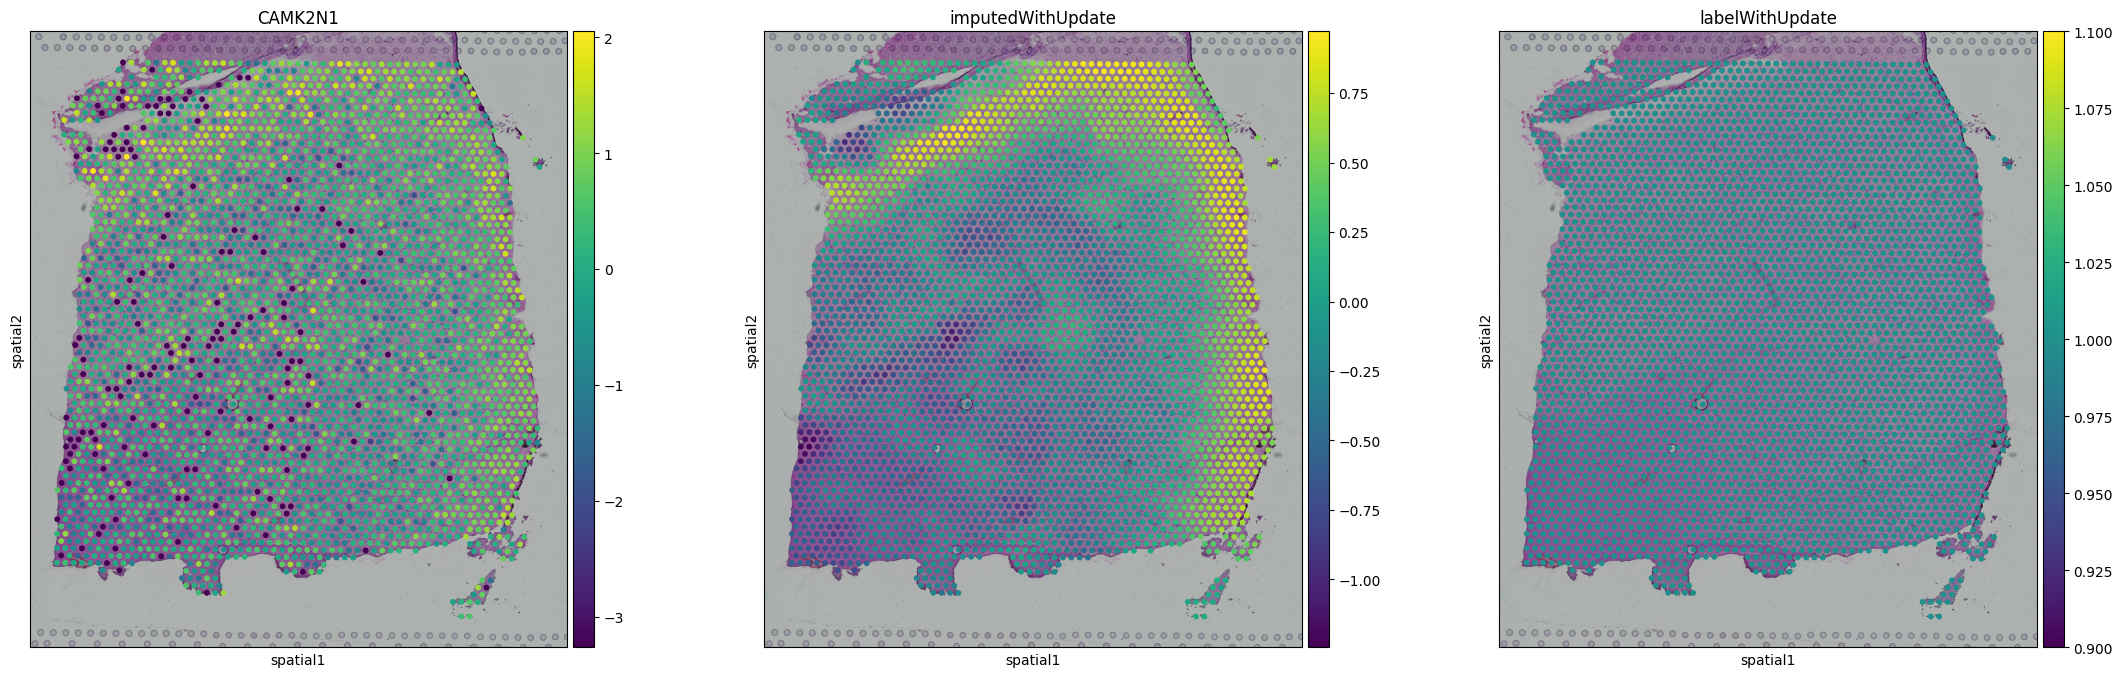

In [110]:
adata.obs['labelWithUpdate']= geneGraph.label
adata.obs['imputedWithUpdate']= geneGraph.imputedExp
sc.pl.spatial(adata, color=[targetGene, 'imputedWithUpdate','labelWithUpdate'])

In [33]:
set(geneGraph.label)

{1}

In [93]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=2)
gmm.fit(adata[:,targetGene].X)
gmm.predict(adata[:,targetGene].X)

array([0, 1, 0, ..., 0, 1, 0])